#### In this notebook we aim to use the Word2Vec approach for finding relevant clusters of job skills. The KMeans cluster models are based on the similarity function from word2vec. We also experiment with TFIDF to observe the importance of job-skill related words in our vocabulary. 

* Importing the required packages : pandas, numpy and gensim (for word2Vec)
* Please note: The file `requirements.txt` contains information of all packages with their required versions. Instructions to execute them is provided in the `README.md` file. 

In [1]:
from gensim.models import Word2Vec
import numpy as np
import pickle
import pandas as pd

C:\Users\gargm\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


###### Custom Imports:
* The folder `PreprocessingUtils` contains
 * profile_segregation.py : Data collection scripts for reading job description from indeed job posts (csvs) 
 * preprocess_text.py : Data cleaning scripts for a three step cleaning process (stopwords -> stemming -> lemmatization).  

In [2]:
from PreprocessingUtils.preprocess_text import Preprocess
from PreprocessingUtils.profile_segregation import segmentProfiles

### WORD2VEC : 

In [3]:
class word2vec(Preprocess):
    
    def initialize_model(self,corpus,count=1,size=50):
        self.model = Word2Vec(corpus,min_count=count,size=size)
        
    def get_vocab(self):
        return self.model.wv.vocab
    
    def create_correlation_matrix(self,matrix,param="cosine"):
        """ Construct correlation matrix based on param (cosine distance/euclidean distance)
        Args:
        matrix : (pd.datafame) initialized dataframe populated for wordlist
        param : (str) type of distance to calculate (cosine supported) 
        """
        wlist = matrix.index
        for i,elements in matrix.iterrows():
            for k in wlist:
                cnum=0
                if (param=="cosine"):
                    cnum = self.model.wv.distance(i,k)
                elif (param=="word_mover"):
                    cnum = self.model.wv.wmdistance(i,k)
                matrix.loc[i,k]=cnum
        return matrix

In [4]:
if __name__ == '__main__':
    source_location="../data/indeed_ca_dataset_10k.csv"
    model_obj = word2vec(enable_stemming=False,stemmer='Snowball') 
    df = pd.read_csv(source_location,usecols=['keyword','summary'])
    profile_obj = segmentProfiles(segment=True)
    for i,rows in df.iterrows():
            titles = profile_obj.get_job_titles(rows,'keyword',delimiter=";")
            for title in titles: 
                #print(title)
                profile_obj.set_profile_lists(title,str(rows['summary']))

In [5]:
for p in profile_obj.profile_dict.keys():
        print(p)
        str_list = " ".join(profile_obj.profile_dict.get(p))
        corpus = model_obj.clean_text(str_list, enable_bigrams=True) #get the list of list of tokens
        model_obj.initialize_model(corpus,size=300)

machine learning
data analyst
data architect
data engineer
business analytics
business intelligence
data visualization
big data
data scientist
analytics
data science
statistical analyst
statistician


In [4]:
###pickle the trained model for later use 

#to save
#with open("../data/saved_model/model_obj_with_bigrams_10k_segmented.pkl",'wb') as modelfile:
    #pickle.dump(model_obj,modelfile)
#to load
with open("../data/saved_model/model_obj_with_bigrams_10k_segmented.pkl",'rb') as modelfile:
    model_obj = pickle.load(modelfile)

### Section 1: Clustering skills based on word similarities. 
##### To create relevant clusters of buzzwords 
* We require a list of job skill related keywords. For this, we use a set of keywords (with high TFIDF scores ) as a starting point (Initial_words_for_clustering)

* Using similarity function of Word2Vec, we find `topn` most similar words. 
* To prevent the cluster plot from getting over populated, we set the max_limit of words to say, 200. 

In [5]:
##TODO: include check for matching if initial words are contained in bigrams as well.  

from ClusterPlotUtils import *
#cluster_plot(model_obj,5)
#plt.text(model_obj.model.wv.vocab.keys())
#w = model_obj.model.wv.most_similar("tensorflow",topn=15)
#init_words_for_clustering = ['python','ml','spark','html','javascript','tensorflow']
init_words = ['tensorflow','spark','python','weka','ml','nlp','scikit','nlp','html','javascript','keras','seaborn','pandas','numpy','rstudio','tableau','ai']
init_words_for_clustering = [w for w in init_words if w in model_obj.model.wv.vocab]
buzzwords = find_similar_keywords(model_obj,init_words=init_words_for_clustering, max_limit=5000, topn=20)
print("Total buzzwords selected : {}".format(len(buzzwords)))

Total buzzwords selected : 5004


#### Bar Plots for top buzzwords in different data industries

In [11]:
# Ref. https://stackoverflow.com/questions/434287/what-is-the-most-pythonic-way-to-iterate-over-a-list-in-chunks
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

('all text',)


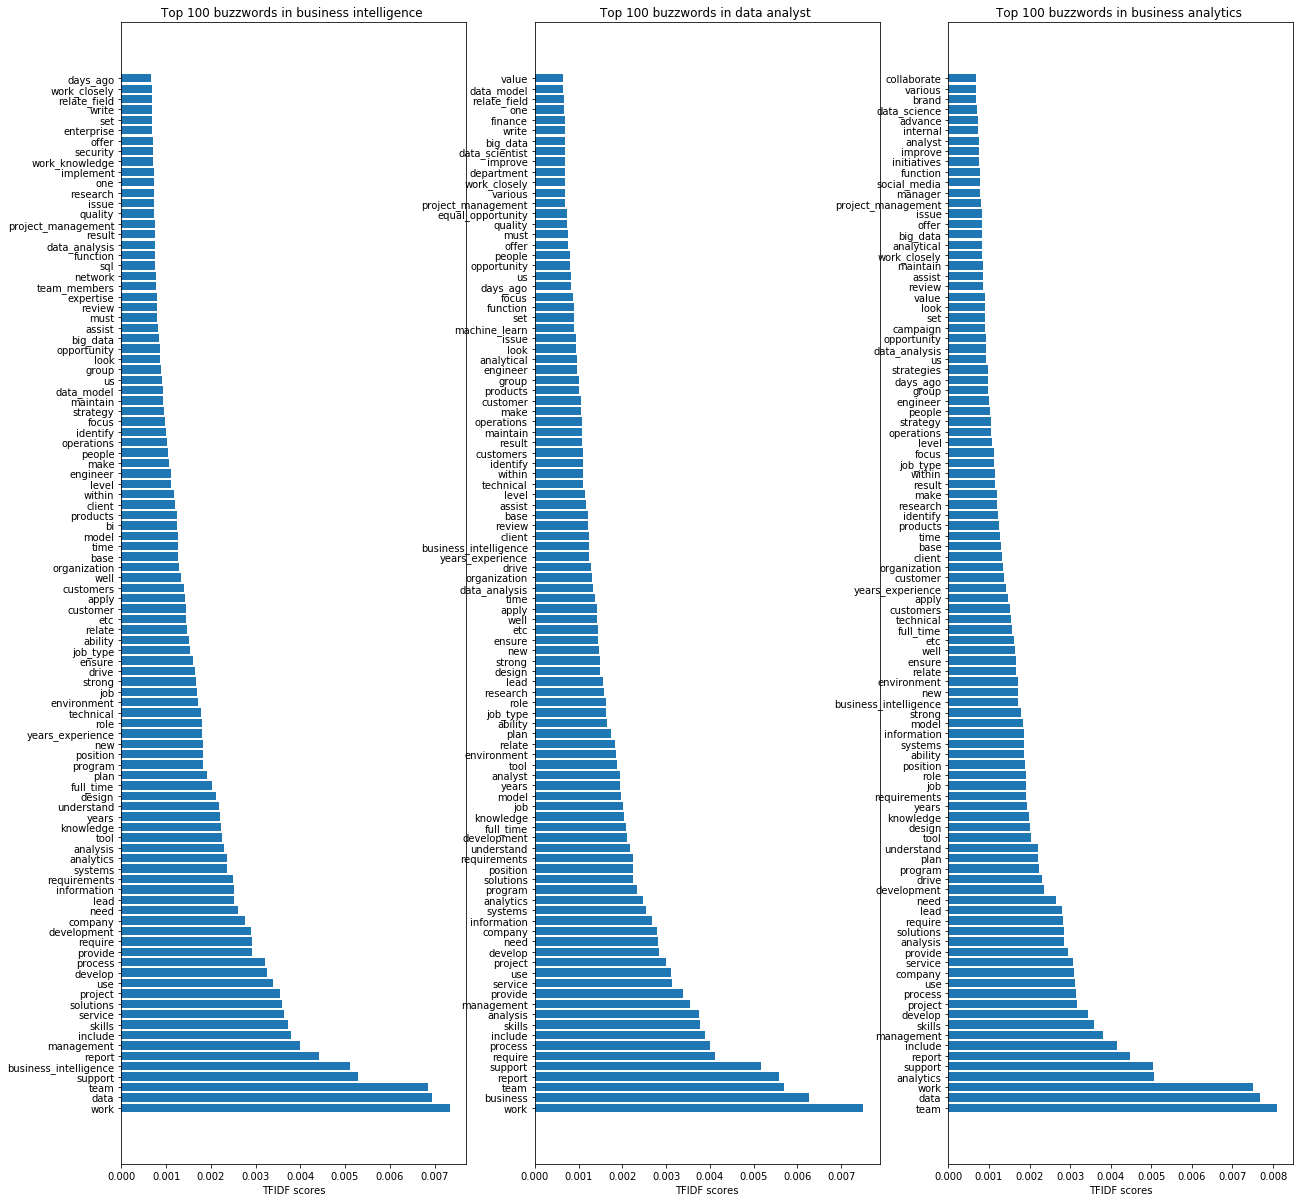

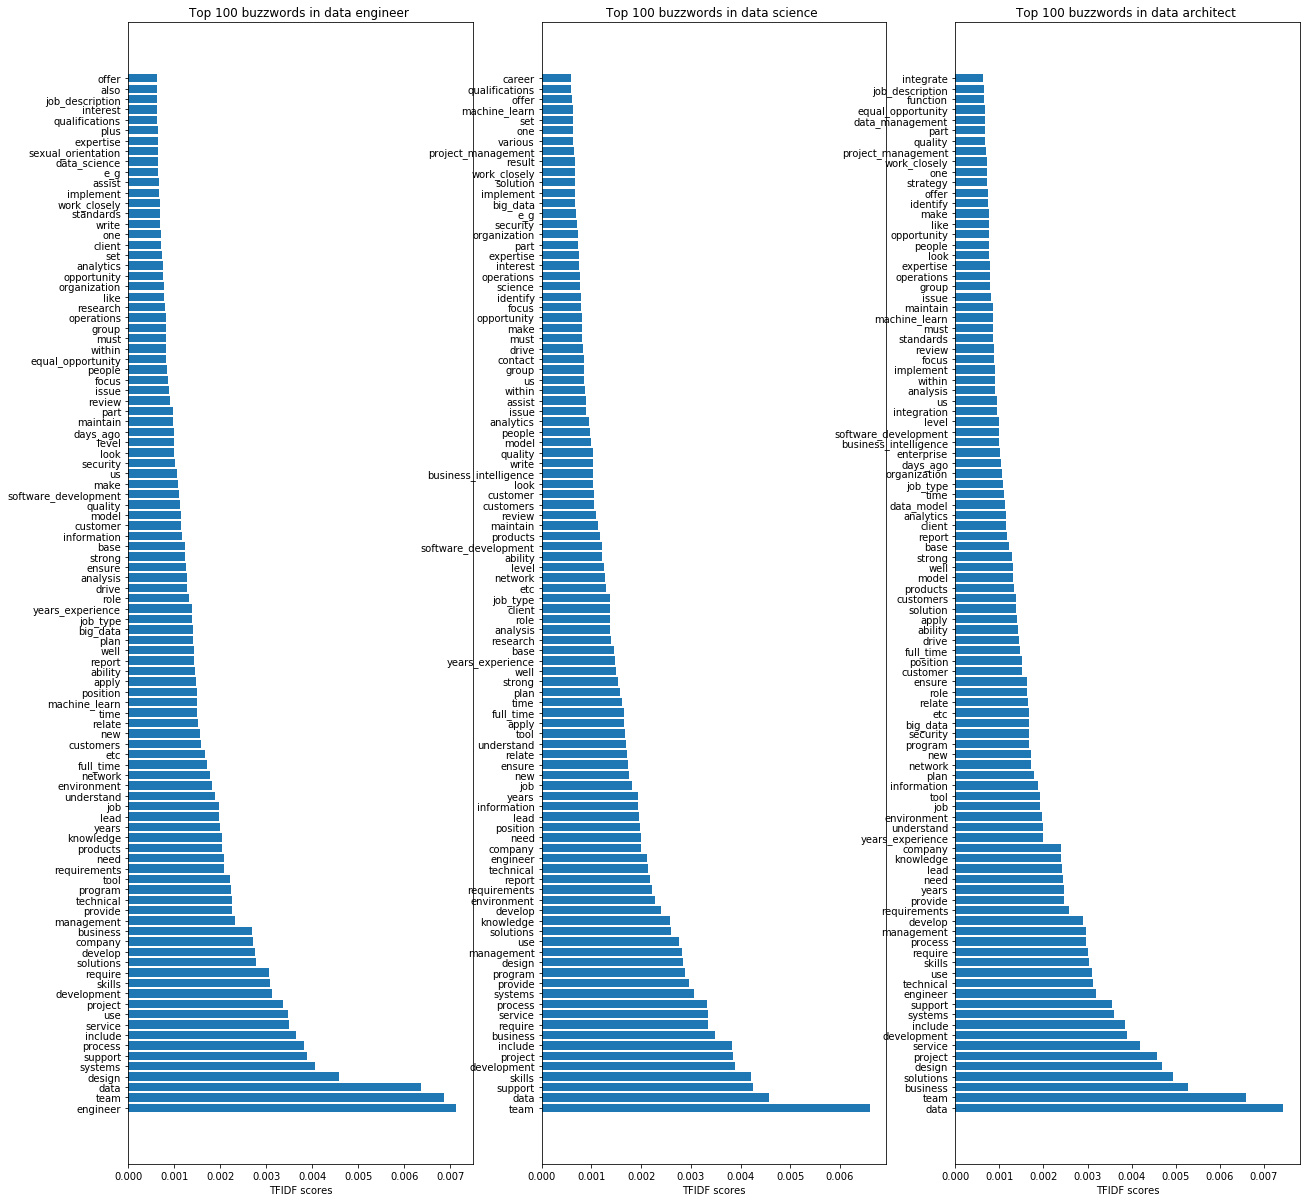

In [21]:
dc = get_tfidf_scores(buzzwords,segmented=True)
max_values_to_consider = 100
figures_per_row = 3 #Number of figures required for every row in plot
dc_keys = [t for t in dc.keys() if (t=='all text')]# and t!='statistical analyst')] #Remove the elements for which you need no plots
for g,keys in enumerate(grouper(dc_keys,figures_per_row)):
    print(keys)
    eliminate_topn = 2 #number of words to eliminate (because of very high tfidf scores)
    fig,ax = plt.subplots(nrows=1, ncols= figures_per_row,figsize=(21,21))
    for i,k in enumerate(keys):
        if(k==None):
            break;
        df= dc[k]
        df['tfidf_scores'] = df['tfidf_scores'].map(lambda x: float(x))
        df = df.sort_values(by=['tfidf_scores'],ascending=False)[eliminate_topn:max_values_to_consider+eliminate_topn] 
        x = df['tfidf_scores']
        y = df['features']
        y_pos = np.arange(len(y))
        try:
            ax[i-1].barh(y_pos,x,tick_label=y)
            ax[i-1].set_title("Top {} buzzwords in {} ".format(max_values_to_consider,k))
            ax[i-1].set_xlabel("TFIDF scores")
        except TypeError as e:
            #When no suplots are required to be created.
            ax.barh(y_pos,x,tick_label=y)
            ax.set_title("Top {} buzzwords in {} ".format(max_values_to_consider,k))
            ax.set_xlabel("TFIDF scores")
    plt.savefig("../plots/tfidf_score_based_skill/bigrams/3_{}.jpg".format(g),dpi=800)
    #plt.show()

In [14]:
print(dc.keys())

dict_keys(['all text'])


## Clustering : KMeans
#### Using Dimensionality reduction for cluster plots: 
* TSNE
* PCA 

**Validation of clusters using Average Silhouette Method:** In order to find how good the clusters form from different approaches , we use Silhouette scoring method from sklearn metrics library. A silhouette score measures the quality of a clustering. That is, it determines how well each object lies within its cluster. A high average silhouette width indicates a good clustering. The optimal number of clusters k is the one that maximize the average silhouette over a range of possible values for k
A curve is plotted for different methods used based on the number of clusters, k, ranging from [2-20]. The metric of evaluation used was “cosine” as it tends to perform better than euclidean distances.


In [ ]:
n_clusters=50
score_dc_PCA = validate_clusters_silhoutte(model_obj,vocab=buzzwords,n_cluster=n_clusters,reduction_method='PCA',scores=dict())
score_dc_TSNE = validate_clusters_silhoutte(model_obj,vocab=buzzwords,n_cluster=n_clusters,reduction_method='TSNE',scores=dict())

#### Plotting average silhouette scores ####
plt.figure(figsize=(10,10))
plt.plot(score_dc_PCA.keys(),score_dc_PCA.values(),label="PCA")
plt.plot(score_dc_TSNE.keys(),score_dc_TSNE.values(),label="TSNE")
plt.xlabel("No. of clusters (k)")
plt.ylabel("Average Silhouette Score for cluster validation")
plt.legend()
plt.grid()
plt.savefig("../plots/PCA_vs_TSNE_{}.jpg".format(n_clusters),dpi=400)
plt.show()

Based on the score above, it is clear that TSNE performs better as we increase k. 

In [ ]:
cluster_dict = cluster_plot(model_obj,n_clusters=5, vocab=buzzwords,reduction_method='TSNE')

In [154]:
##### PRINT OUT WORDS IN DIFFERENT CLUSTERS:
for items in cluster_dict.keys():
    print("Cluster no {}: ".format(items))
    print(cluster_dict[items])

Cluster no 2: 
['yearscoding', 'jupyter', 'platfom', 'weka', 'deepnet', 'sklearn', 'essayez', 'ussite', 'wabbit', 'paddlepaddle', 'statsmodel', 'scikit', 'spacy', 'statsmodels', 'lingpipe', 'sultats', 'scalanlp', 'gephi', 'dvp', 'eigen', 'theano', 'tensorflow', 'mlpack', 'mllib', 'tidyverse', 'r', 'julia', 'graphx', 'igraph', 'alisera', 'uima', 'syntaxnet', 'disponibilit', 'osirix', 'bioconductor', 'phyton', 'novoaccommodation', 'lasagne', 'pondra', 'comsol', 'scikitlearn', 'madlib', 'welcometitle', 'knime', 'pythonexcellentcapabilities', 'cgroup', 'jmp', 'stata', 'encog', 'clearnlp', 'eporting', 'aimms', 'winbugs', 'bigrf', 'pyplot', 'kaldi', 'statistica', 'aliser', 'strom', 'forestiers', 'soudre', 'mahout', 'smalltalk', 'equired', 'quanteda', 'networkx', 'rapidminer', 'publique', 'chainer', 'scikits', 'sparkmlib', 'deeppy', 'minitab', 'octave', 'pondre', 'mlr', 'cntk', 'xgboost', 'gensim', 'mun', 'pytorch', 'randomforest', 'scipy', 'htk', 'eviews', 'mlib', 'corenlp', 'nltk', 'numpy',

##### Tunable Parameters:
**There are several parameters (listed below) that can be tuned in order to experiment with the kind of clusters created.**
* Initial_words_for_clustering : List of initial words is currently chosen from TFIDF values which can potentially be experimented accordingly. 
* topn : Integer value that determines the number of similar words to be considered for clustering.
* max_limit : Threshold value that determines the upper limit on the number of words to be considered. Please note that the total number of words selected will be in the range : (max_limit-topn, max_limit+topn)

### BuzzWords (based on TFIDF scores)

In [16]:
from ClusterPlotUtils import *

def create_wordclouds(buzzwords,use_tfidf=False, max_words=100, file_to_write="../plots/wordclouds.jpg"):
        """
        Create wordclouds for the keywords supplied, if use_tfidf is set to true, the tfidf_scores are used as frequencies
        Args:
        buzzwords: (list) of keywords supplied
        use_tfidf: (bool) True if tfidf scores are used as the word frequency (size)
        file_to_write: (str) path where the file is to be written
        :return: None
        """

        if use_tfidf:
                scores_dc = get_tfidf_scores(buzzwords,segmented=False)  # use TFIDF scores
                
                
        else:
                scores = [(i,random.random()) for i in buzzwords]
        #wc = WordCloud(width=320, height=250, color_func=defined_color_func, background_color='white',
        #          scale=2, prefer_horizontal=0.7).generate_from_frequencies(scores)
        ##### Code without using wordcloud package
        plt.figure(figsize=(9, 5), dpi=320)
        hsl_cols = ['#d5691f', '#1a416f', '#35709e', '#59d9c4', '#2e9b89', '#f5ab47', '#f58d47', '#f31c7f', '#fe5033']
        for word, score in scores:
                color = random.choice(hsl_cols)
                x = random.random()
                y = random.random()
                plt.text(y, x, word, fontweight='bold', color=color)
        #adjusting limits on x and y axis to prevent words from overflowing out of the frame
        plt.xlim(0.0,1.16)
        plt.ylim(0.0,1.05)
        plt.savefig(file_to_write)
        plt.show()

create_wordclouds(buzzwords,use_tfidf=True, max_words= 200)

In [18]:
score_dc

{'all text':                features tfidf_scores
 1                  data  0.015109823
 4              business  0.009004661
 10               design  0.004456732
 20              develop  0.004023906
 21              process  0.003921128
 24               report   0.00366744
 25             software  0.003616232
 27            solutions  0.003546386
 28                  new  0.003513273
 33               strong   0.00325868
 34                build  0.003257956
 35            analytics  0.003212538
 36              systems  0.003211996
 39             analysis  0.003070857
 43                 tool  0.002741713
 50                model  0.002517882
 55                 test  0.002332954
 58               create  0.002283374
 60              science  0.002171006
 69             research  0.001977573
 85                 look    0.0016924
 89              machine  0.001654582
 91              deliver  0.001649154
 92             products  0.001648068
 99                  sql  0.001591251


### Correlation matrix for top n words (based on cosine/wm distances)

In [168]:
import random
import seaborn as sns
max_values_to_consider = 50
key1 = ['tensorflow','ggplot','python','weka','ml','nlp','scikit','keras','seaborn','pandas','numpy','rstudio','tableau','ai']

In [187]:
keys = []
for i in range(max_values_to_consider-len(key1)):
    word = random.choice(buzzwords).strip() 
    if word not in key1:
        keys.append(word)
keys = key1+keys
matrix = pd.DataFrame([],columns=None,index=keys)
param = "cosine"
matrix = model_obj.create_correlation_matrix(matrix,param=param)
#model_obj.model.wv.distance("ml","python")


adj = matrix.values
plt.figure(figsize=(22,15))
# Elements to be printed on the x axis. Feel free to change the column name here : 'subreddit' -> 'yourColumn'
xticks = ['{}'.format(i) for i in matrix.index]
ax = sns.heatmap(adj,linewidth=0.5,cmap='YlGnBu',xticklabels=xticks,yticklabels=xticks)
plt.xlabel("Correlation matrix for {} distances (100k records)".format(param))
plt.savefig("../plots/correlation_{}_matrix_100k.jpg".format(param),dpi=400)

## Venn Diagram

In [6]:
from matplotlib_venn import venn3

In [22]:
dc = get_tfidf_scores(buzzwords,segmented=True)
keywords = set(buzzwords)
skill_lis = []
words_list =[]
groups = [("analytics","business analytics","business intelligence"), ("big data", "data scientist","machine learning"), 
          ("big data", "statistical analyst", "data analyst"), ("data architect", "data engineer","data visualization")]

def get_venn_data(feature_dc, group, buzzwords_set,word_list=[]):
    for el in group:
        common_words = set(feature_dc[el].features).intersection(buzzwords_set)
        #print("{}-{}".format(el,len(common_words)))
        word_list.append(common_words)
    return word_list
    

for i,elements in enumerate(groups):
    words_list = get_venn_data(dc,elements,keywords,[])
    plt.figure(figsize=(8,8))
    v = venn3(words_list,set_labels=elements)
    plt.savefig("../plots/venn_diagrams/{}.jpg".format(i))